In [1]:
# referenced from https://qiita.com/takubb/items/7d45ae701390912c7629
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms

from torch.utils.data import DataLoader, ConcatDataset

import os
import random
import glob
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pickle

from PIL import Image

# from tqdm import tqdm  #コマンドラインで実行するとき
from tqdm.notebook import tqdm  # jupyter で実行するとき
from models import RESNETLIKE, MyModel, MyModel_shallow

In [2]:
# リソースの指定（CPU/GPU）
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
# データセットの作成
trans = transforms.Compose([
    transforms.ToTensor()
])

class FocusPatchDataset(torch.utils.data.Dataset):
    # FILEはデータが入っていたファイル、imsize = 画像サイズ、psize = パッチサイズ
    def __init__(self, DIR, imsize, psize, channels, DEPTH_GAP, n_sample, transforms):
        
        # ground truth depthを読み込むdd
        with open(os.path.join(DIR,'depth.pkl'),"rb") as f:
            self.gt = pickle.load(f)
        
        if self.gt is None:
            print('cannot find ', os.path.join(DIR,'depth.pkl'))
            return None
        
        self.files = glob.glob(os.path.join(DIR,'[0-9]*.bmp'))
        # print(self.files)
        self.fvalues = []
        for fn in self.files:
            self.fvalues.append(int(os.path.splitext(os.path.basename(fn))[0]))
        self.fvalues.sort()
        
        self.DIR = DIR
        self.DEPTH_GAP = DEPTH_GAP
        self.psize = psize
        self.channels = channels
        self.transforms = transforms
        self.n_sample = n_sample

        self.imsize = imsize
        self.psize = psize
        self.locs = []

        # サンプル対象となる点を設定する
        w = imsize[0]
        h = imsize[1]        
        for i in range(self.n_sample):
            xx = random.randint(0,w-self.psize-1)
            yy = random.randint(0,h-self.psize-1)
            self.locs.append([xx,yy])

        print('locations', self.locs)
    
    def __len__(self):
        length = (len(self.fvalues) - self.DEPTH_GAP)*self.n_sample
        return length

    def __getitem__(self, index):
        imgs = []

        # n: file (data) index, m: point index
        n = index // self.n_sample
        m = index % self.n_sample

        x = self.locs[m][0]
        y = self.locs[m][1]
        
        val = float(self.gt[y,x]) - float(self.fvalues[n])

        FILE1 = os.path.join(self.DIR,f'{self.fvalues[n]:04d}.bmp')
        FILE2 = os.path.join(self.DIR,f'{self.fvalues[n+self.DEPTH_GAP]:04d}.bmp')

        # print(self.gt[y,x], self.fvalues[n], val, FILE1, FILE2, x, y)
        
        img = Image.open(FILE1)
        img = img.crop((x, y, x+self.psize, y+self.psize))
        img = img.convert('L')
        img = np.array(img)
        img = np.array(img).astype('float32')
        imgs.append(img)

        img = Image.open(FILE2)
        img = img.crop((x, y, x+self.psize, y+self.psize))
        img = img.convert('L')
        img = np.array(img)
        img = np.array(img).astype('float32')
        imgs.append(img)
        
        out = np.stack(imgs,axis=2)
        #print(out.shape)
        
        return self.transforms(out), val

In [4]:
PSIZE = 65
DEPTH_GAP = 100
N_SAMPLE = 20

# merge several dataset together
dataset1 = FocusPatchDataset(DIR = 'data/202410041703', imsize = [1600,1200], 
                            psize=PSIZE, channels=2, n_sample=N_SAMPLE, 
                            DEPTH_GAP=DEPTH_GAP, transforms = trans)
dataset2 = FocusPatchDataset(DIR = 'data/202410041747', imsize = [1600,1200], 
                            psize=PSIZE, channels=2, n_sample=N_SAMPLE, 
                            DEPTH_GAP=DEPTH_GAP, transforms = trans)
dataset3 = FocusPatchDataset(DIR = 'data/202410080808', imsize = [1600,1200], 
                            psize=PSIZE, channels=2, n_sample=N_SAMPLE, 
                            DEPTH_GAP=DEPTH_GAP, transforms = trans)
dataset4= FocusPatchDataset(DIR = 'data/202410080819', imsize = [1600,1200], 
                            psize=PSIZE, channels=2, n_sample=N_SAMPLE, 
                            DEPTH_GAP=DEPTH_GAP, transforms = trans)

dataset = torch.utils.data.ConcatDataset([dataset1,dataset2,dataset3,dataset4])

locations [[1285, 152], [502, 450], [994, 453], [118, 590], [1345, 117], [358, 124], [84, 882], [474, 172], [634, 165], [333, 42], [487, 752], [475, 752], [313, 366], [253, 328], [1412, 590], [1381, 510], [1390, 77], [1390, 24], [942, 959], [761, 301]]
locations [[290, 535], [736, 447], [673, 660], [888, 570], [888, 1064], [1423, 921], [1058, 811], [1190, 1066], [96, 97], [605, 489], [0, 485], [1005, 677], [271, 201], [612, 123], [560, 496], [72, 237], [109, 473], [1384, 778], [4, 312], [94, 96]]
locations [[1230, 264], [1201, 847], [868, 784], [474, 134], [1287, 990], [1418, 339], [829, 146], [667, 983], [288, 307], [508, 549], [1305, 1082], [348, 441], [1132, 41], [1244, 505], [89, 645], [1471, 281], [1387, 333], [256, 51], [890, 666], [208, 17]]
locations [[727, 860], [626, 1009], [341, 941], [900, 1113], [961, 735], [1416, 432], [590, 703], [675, 207], [773, 1121], [70, 15], [95, 49], [615, 792], [1242, 1110], [1000, 948], [171, 738], [654, 857], [696, 135], [1444, 133], [1104, 544

In [5]:
train_set, test_set = torch.utils.data.random_split(dataset, [0.7,0.3])
len(dataset)

20040

In [6]:
# データローダーの作成
train_loader = torch.utils.data.DataLoader(train_set,
                                           batch_size=256,  # バッチサイズ
                                           shuffle=True,  # データシャッフル
                                           num_workers=0,  # 高速化
                                           pin_memory=True  # 高速化                                      
                                           )
test_loader = torch.utils.data.DataLoader(test_set,
                                          batch_size=256,
                                          shuffle=True,
                                          num_workers=0,  # 高速化
                                          pin_memory=True  # 高速化                                                   
                                          )

In [7]:
# モデル・損失関数・最適化アルゴリスムの設定
LOAD_WEIGHT = True
# model = RESNETLIKE(channels=2).to(device)
model = MyModel(channels=2)
#model = MyModel_shallow(channels=2).to(device)
weight_file = f"weights/weight_{PSIZE}_{DEPTH_GAP}.pth"

if LOAD_WEIGHT == True:
    # 学習済みモデルのロード
    print("load weight", weight_file)
    model.load_state_dict(torch.load(weight_file))
    model.eval()

model = model.to(device)

criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters())
#optimizer = optim.SGD(model.parameters())

load weight weights/weight_65_100.pth


In [8]:
# モデル訓練関数
def train_model(model, train_loader, test_loader):
    # Train loop ----------------------------
    model.train()  # 学習モードをオン
    train_batch_loss = []
    for data, val in train_loader:
        # GPUへの転送
        data, val = data.to(device), val.to(device)
        # 1. 勾配リセット
        optimizer.zero_grad()
        # 2. 推論
        output = model(data)
        val = val.unsqueeze(1).to(torch.float32)
        # 3. 誤差計算
        loss = criterion(output, val)
        # 4. 誤差逆伝播
        loss.backward()
        # 5. パラメータ更新
        optimizer.step()
        # train_lossの取得
        train_batch_loss.append(loss.item())

    # Test(val) loop ----------------------------
    model.eval()  # 学習モードをオフ
    test_batch_loss = []
    with torch.no_grad():  # 勾配を計算なし
        for data, val in test_loader:
            data, val = data.to(device), val.to(device)
            output = model(data)
            val = val.unsqueeze(1).to(torch.float32)
            loss = criterion(output, val)
            test_batch_loss.append(loss.item())

    return model, np.mean(train_batch_loss), np.mean(test_batch_loss)

  0%|          | 0/50 [00:00<?, ?it/s]

Train loss: 2150.895, Test loss: 1591.160
Train loss: 1416.572, Test loss: 1143.887
Train loss: 1065.218, Test loss: 967.180
Train loss: 829.775, Test loss: 861.067
Train loss: 693.299, Test loss: 686.463
Train loss: 695.759, Test loss: 795.470
Train loss: 683.471, Test loss: 719.230
Train loss: 562.303, Test loss: 548.154
Train loss: 465.562, Test loss: 461.051
Train loss: 483.795, Test loss: 465.123
Train loss: 426.032, Test loss: 420.848
Train loss: 391.530, Test loss: 427.198
Train loss: 370.722, Test loss: 375.833
Train loss: 351.659, Test loss: 395.177
Train loss: 329.508, Test loss: 361.203
Train loss: 316.305, Test loss: 374.835
Train loss: 347.450, Test loss: 387.773
Train loss: 367.792, Test loss: 397.686
Train loss: 325.437, Test loss: 387.549
Train loss: 319.926, Test loss: 340.109
Train loss: 281.034, Test loss: 357.149
Train loss: 264.917, Test loss: 340.880
Train loss: 300.309, Test loss: 357.778
Train loss: 257.931, Test loss: 306.474
Train loss: 256.218, Test loss: 291

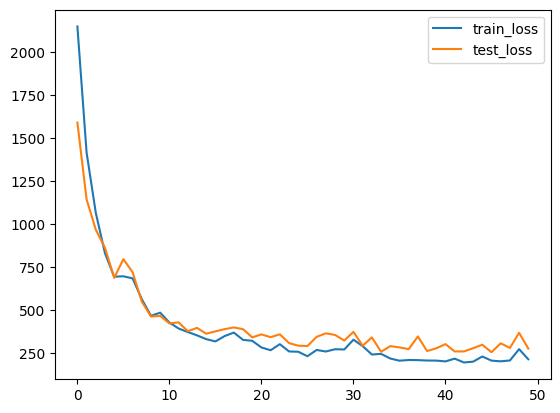

In [9]:
if __name__ == "__main__":
    # 訓練の実行
    epoch = 50
    train_loss = []
    test_loss = []
    
    for epoch in tqdm(range(epoch)):
        model, train_l, test_l = train_model(model,train_loader,test_loader)
        train_loss.append(train_l)
        test_loss.append(test_l)    
        # 10エポックごとにロスを表示
        #if epoch % 5 == 0:
        print(f"Train loss: {train_loss[-1]:.3f}, Test loss: {test_loss[-1]:.3f}")
    
    # 学習状況（ロス）の確認
    plt.plot(train_loss, label='train_loss')
    plt.plot(test_loss, label='test_loss')
    plt.legend()

    # モデルの保存
    print("save weight as: ", weight_file)
    torch.save(model.state_dict(), weight_file)

In [12]:
# 学習済みモデルから予測結果と正解値を取得
def retrieve_result(model, dataloader):
    model.eval()
    preds = []
    labels = []
    # Retreive prediction and labels
    with torch.no_grad():
        for data, label in dataloader:
            data, label = data.to(device), label.to(device)
            output = model(data)
            # Collect data
            preds.append(output)
            labels.append(label)
    # Flatten
    preds = torch.cat(preds, axis=0)
    labels = torch.cat(labels, axis=0)
    # Returns as numpy (CPU環境の場合は不要)
    preds = preds.cpu().detach().numpy()
    labels = labels.cpu().detach().numpy()
    return preds, labels


# データを作って評価してみる
dataset = FocusPatchDataset(DIR = 'data/202410041747', imsize = [1600,1200], 
                            psize=PSIZE, channels=2, n_sample=1, 
                            DEPTH_GAP=DEPTH_GAP, transforms = trans)
test_loader = torch.utils.data.DataLoader(dataset, batch_size=256, shuffle=False)
preds, labels = retrieve_result(model, test_loader)

locations [[456, 575], [164, 193], [441, 361], [272, 362], [728, 420], [617, 330], [389, 121], [951, 350], [1130, 448], [48, 159], [986, 727], [1430, 211], [1369, 985], [81, 98], [974, 587], [1327, 872], [1386, 594], [1365, 886], [407, 258], [1286, 735], [158, 637], [551, 291], [1183, 722], [977, 227], [888, 108], [509, 181], [244, 372], [955, 714], [1203, 119], [1451, 723], [1000, 978], [1392, 236], [1247, 837], [1115, 123], [450, 252], [118, 919], [549, 560], [1127, 53], [689, 120], [549, 373], [713, 741], [1489, 465], [967, 819], [533, 150], [847, 944], [711, 761], [113, 764], [191, 535], [547, 529], [1138, 104], [1086, 676], [678, 765], [833, 546], [569, 1074], [1278, 171], [227, 620], [1521, 1124], [55, 393], [1425, 907], [1350, 221], [1114, 428], [1512, 960], [902, 1017], [1361, 778], [783, 733], [153, 852], [1247, 908], [1247, 42], [86, 979], [1498, 414], [709, 116], [338, 489], [672, 367], [772, 160], [245, 1025], [551, 433], [1084, 732], [819, 617], [371, 845], [1049, 774], [1

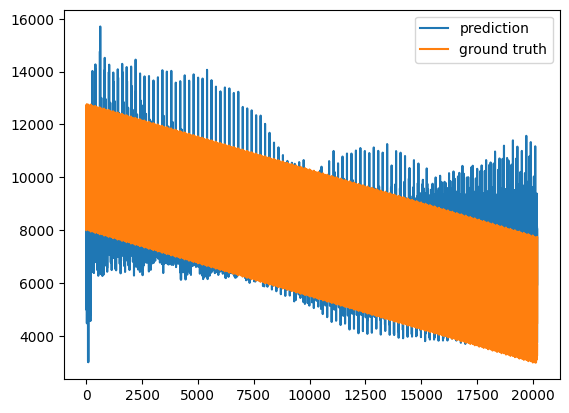

In [14]:
if __name__ == "__main__":
    plt.plot(preds, label="prediction")
    plt.plot(labels, label='ground truth')
    plt.legend()